# SMOTE Impact to SVM Models

We will run two SVM models, one without using SMOTE and the other one with SMOTE.

We are interested to see what kind of impact SMOTE could introduce.

In [ ]:
import os

import pandas as pd
import numpy as np

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE


## Load Analytical Base Table

In [ ]:
df = pd.read_csv(os.path.join("/content/complete_churn_df3"))
print(f"Dataframe dimensions: {df.shape}")
df.head()

Dataframe dimensions: (14771, 40)


,CUSTOMER_COD,COMPANY_COD,TERRITORY_ID,TERRITORY_COD,TERRITORY,DITRIBUTION_MODEL,CUSTOMER_SEGMENT_ID,LOCATION_ID,LOCATION_COD,CUSTOMER_SEG,...,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment_Label,Seg_Num,R_Next_1Month,Churn
0,7781241,M100,106,M00005 ...,Sud ...,DIRECT ...,7,13,M120,DL ...,...,43,9.0,1,4,0,5,Standard Customer,2.0,No,1
1,7781241,M200,106,M00005 ...,Sud ...,DIRECT ...,7,405,M250,DL ...,...,43,9.0,1,4,0,5,Standard Customer,2.0,No,1
2,7781248,M200,106,M00005 ...,Sud ...,DIRECT ...,8,21,M240,CAFE ...,...,9,40.0,2,0,2,4,Basic Customer,1.0,No,2
3,7781663,M100,106,M00005 ...,Sud ...,DIRECT ...,8,13,M120,CAFE ...,...,27,110.0,0,3,4,7,Standard Customer,2.0,No,1
4,7781663,M200,106,M00005 ...,Sud ...,DIRECT ...,8,405,M250,CAFE ...,...,27,110.0,0,3,4,7,Standard Customer,2.0,No,1


In [ ]:
df = df.drop(columns=['DITRIBUTION_MODEL','CUSTOMER_SEGMENT_ID','TERRITORY_ID','TERRITORY_COD','LOCATION_ID','R_Next_1Month','LOCATION_COD','CUSTOMER_SEG','OCCASION','CANAL_COD','OCCASION_COD','CUSTOMER_CATEGORY_COD','SIGN','HYBRID_DISTRIBUTOR_ID','CREDIT'])

### Separate dataframe into separate object

In [ ]:

# Convert specified ID columns to categorical
id_columns_to_convert = [

    'SALES_ROUTE',
    'CUSTOMER_COD'
]

for col in id_columns_to_convert:
    df[col] = df[col].astype('category')

# Verify the changes
print(df.dtypes)


CUSTOMER_COD         category
COMPANY_COD            object
TERRITORY              object
CANAL                  object
CUSTOMER_CATEGORY      object
OPPORTUNITY            object
SEGMENT                object
CITY                   object
DISCOUNT_COD           object
SEGMENTATION           object
COM_DELETE             object
SOC_DELETE             object
GEN_DELETE             object
PARTNER_CLASS          object
SALES_ROUTE          category
Recency                 int64
Frequency               int64
Monetary              float64
Recency_Score           int64
Frequency_Score         int64
Monetary_Score          int64
RFM_Score               int64
Segment_Label          object
Seg_Num               float64
Churn                   int64
dtype: object


### Separate dataframe into separate object

In [ ]:
# Object for target variable
y = df.Churn

# object for input features
X = df.drop(['Churn'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)

(14771, 24) (14771,)


In [ ]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['Recency',
 'Frequency',
 'Monetary',
 'Recency_Score',
 'Frequency_Score',
 'Monetary_Score',
 'RFM_Score',
 'Seg_Num']

In [ ]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

['COMPANY_COD',
 'TERRITORY',
 'CANAL',
 'CUSTOMER_CATEGORY',
 'OPPORTUNITY',
 'SEGMENT',
 'CITY',
 'DISCOUNT_COD',
 'SEGMENTATION',
 'COM_DELETE',
 'SOC_DELETE',
 'GEN_DELETE',
 'PARTNER_CLASS',
 'Segment_Label']

In [ ]:
def class_count(a):
    counter=Counter(a)
    kv=[list(counter.keys()),list(counter.values())]
    dff = pd.DataFrame(np.array(kv).T, columns=['Exited','Count'])
    dff['Count'] = dff['Count'].astype('int64')
    dff['%'] = round(dff['Count'] / a.shape[0] * 100, 2)
    return dff.sort_values('Count',ascending=False)

In [ ]:
class_count(y)

,Exited,Count,%
0,1,5273,35.70
2,3,4016,27.19
1,2,3193,21.62
3,0,2289,15.50


## Create a Train Test Split

In [ ]:
random_state = 10

# Split X and y into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=random_state,
                                                   stratify=df.Churn)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

10339 4432 10339 4432


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10339 entries, 10164 to 13781
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   CUSTOMER_COD       10339 non-null  category
 1   COMPANY_COD        10339 non-null  object  
 2   TERRITORY          10339 non-null  object  
 3   CANAL              10339 non-null  object  
 4   CUSTOMER_CATEGORY  10339 non-null  object  
 5   OPPORTUNITY        10339 non-null  object  
 6   SEGMENT            10339 non-null  object  
 7   CITY               10339 non-null  object  
 8   DISCOUNT_COD       10339 non-null  object  
 9   SEGMENTATION       10339 non-null  object  
 10  COM_DELETE         10339 non-null  object  
 11  SOC_DELETE         10339 non-null  object  
 12  GEN_DELETE         10339 non-null  object  
 13  PARTNER_CLASS      10339 non-null  object  
 14  SALES_ROUTE        10339 non-null  category
 15  Recency            10339 non-null  int64   
 16  Frequ

## Pre-processing Pipeline

### Scale numerical data and encode categorical data
Construct a pre-processing pipeline from the given transformers: MinMaxScaler and OneHotEncoder

Create lists of indexes from the list of column names

Need to be numeric not string to specify columns name in column transformer

In [ ]:
num_features = []

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)

[15, 16, 17, 18, 19, 20, 21, 23]


In [ ]:
cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 22]


In [ ]:
# Define column transformer
# Need to be numeric not string to specify columns name
preprocess = make_column_transformer(
    (MinMaxScaler(), num_features),
    (OneHotEncoder(handle_unknown='ignore'), cat_features)
)
preprocess

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 [15, 16, 17, 18, 19, 20, 21, 23]),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  22])])

## Build Model Pipeline without SMOTE

* To see the impact of SMOTE to our results, wew will first build our pipeline without SMOTE

In [ ]:
# Import classifier
from sklearn.svm import SVC

# Define model with pipeline
model = imbl_pipe(preprocess,
                  SVC(random_state=random_state))

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [15, 16, 17, 18, 19, 20, 21,
                                                   23]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 22])])),
                ('svc', SVC(random_state=10))])

In [ ]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__kernel' : ['linear', 'rbf'],
              'svc__C': [0.001, 0.1, 0.5],
              'svc__gamma': [1, 0.1, 0.01]}
grid = GridSearchCV(model, param_grid, verbose=3, cv= 3, n_jobs=2)


In [ ]:
X_train = X_train.values
X_test = X_test.values

In [ ]:
# Train the model with GridSearch
grid.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          23]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [1, 2,
                                                                          3, 4,
                                                                          5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          22])])),
                                       ('svc', SVC(random_state=10))]),
             n_jobs=2,
             param_grid={'svc__C': [0.001, 0.1, 0.5],
                         'svc__gamma': [1, 0.1, 0.01],
                         'svc__kernel': ['linear', 'rbf']},
             verbose=3)

In [ ]:
print(grid.best_params_)

{'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'linear'}


In [ ]:
 # List the best score
print(grid.best_score_)

0.8318996620353323


In [ ]:
print(f"Training Data Score: {grid.score(X_train, y_train)}")
print(f"Testing Data Score: {grid.score(X_test, y_test)}")

Training Data Score: 0.8358642035013057
Testing Data Score: 0.8264891696750902


In [ ]:
# Make predictions with the hypertuned model
predictions = grid.predict(X_test)
predictions

array([2, 2, 3, ..., 2, 2, 3])

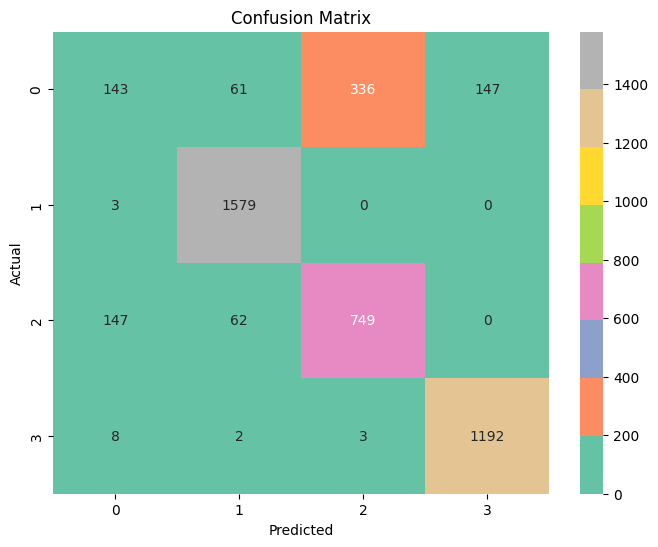

In [ ]:
# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predictions)
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Set2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


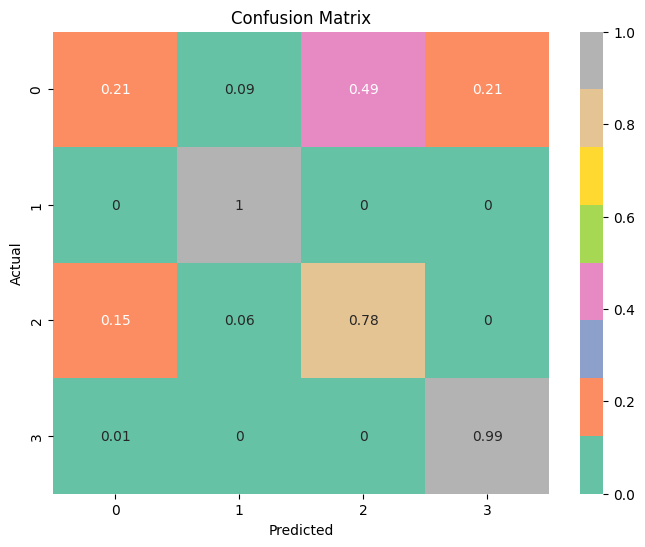

In [ ]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Set2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.48      0.21      0.29       687
           1       0.93      1.00      0.96      1582
           2       0.69      0.78      0.73       958
           3       0.89      0.99      0.94      1205

    accuracy                           0.83      4432
   macro avg       0.75      0.74      0.73      4432
weighted avg       0.80      0.83      0.80      4432



In [ ]:
predictions

array([2, 2, 3, ..., 2, 2, 3])

In [ ]:
pred = grid.predict(X_test[:1])

In [ ]:
print(f"Predicted classes: {pred}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [2]
Actual Labels: [2]


## Build Model Pipeline with SMOTE

* Let's check now the impact of SMOTE to our results

* We are going to use the Pipeline from the imblearn package in place of scikit-learn Pipeline.

* It takes care automatically to re-sample when called fit() on the pipeline, and does not re-sample test data (when called transform() or predict()).

In [ ]:
# Import classifier
from sklearn.svm import SVC

# Define model with pipeline
model_s = imbl_pipe(preprocess,
                  SMOTE(sampling_strategy='auto', random_state=random_state),
                  SVC(random_state=random_state))

model_s

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  [29, 30, 31, 32, 33, 34, 35,
                                                   37]),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [1, 3, 4, 5, 8, 9, 10, 11, 12,
                                                   14, 15, 16, 17, 18, 19, 20,
                                                   21, 22, 23, 24, 25, 26, 28,
                                                   36, 38])])),
                ('smote', SMOTE(random_state=10)),
                ('svc', SVC(random_state=10))])

In [ ]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV

param_grid = {'svc__kernel' : ['linear', 'rbf'],
              'svc__C': [0.001, 0.1, 0.5],
              'svc__gamma': [1, 0.1, 0.01]}
grid = GridSearchCV(model, param_grid, verbose=3, cv= 3, n_jobs=2)

In [ ]:
# Train the model with GridSearch
grid.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         [29,
                                                                          30,
                                                                          31,
                                                                          32,
                                                                          33,
                                                                          34,
                                                                          35,
                                                                          37]),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         [1, 3,
                                                                          4, 5,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          22,
                                                                          23,
                                                                          24,
                                                                          25,
                                                                          26,
                                                                          28,
                                                                          36,
                                                                          38])])),
                                       ('svc', SVC(random_state=10))]),
             n_jobs=2,
             param_grid={'svc__C': [0.001, 0.1, 0.5],
                         'svc__gamma': [1, 0.1, 0.01],
                         'svc__kernel': ['linear', 'rbf']},
             verbose=3)

In [ ]:
 print(grid.best_params_)

{'svc__C': 0.5, 'svc__gamma': 1, 'svc__kernel': 'linear'}


In [ ]:
 # List the best score
print(grid.best_score_)

0.9936166282859539


In [ ]:
print(f"Training Data Score: {grid.score(X_train, y_train)}")
print(f"Testing Data Score: {grid.score(X_test, y_test)}")

Training Data Score: 0.9964213173421027
Testing Data Score: 0.9945848375451264


In [ ]:
# Make predictions with the hypertuned model
predictions_s = grid.predict(X_test)
predictions_s

array([2, 2, 3, ..., 2, 2, 3])

In [ ]:
# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predictions_s)
print(cm)

[[ 678    0    9    0]
 [   0 1582    0    0]
 [  14    0  944    0]
 [   0    0    1 1204]]


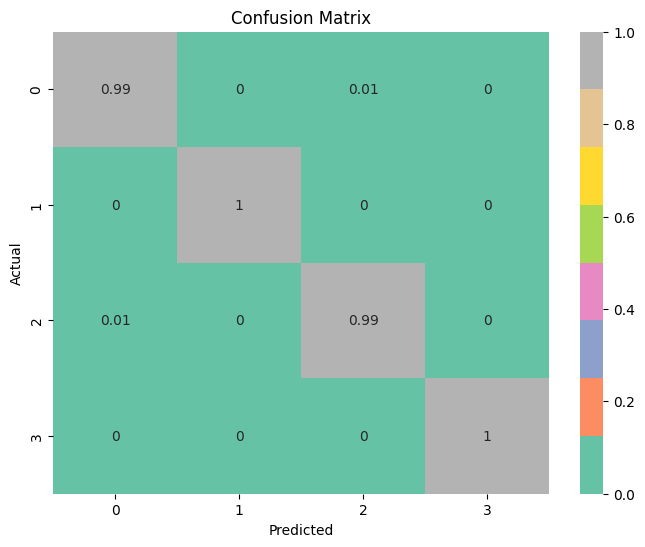

In [ ]:
cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Set2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, predictions_s))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       687
           1       1.00      1.00      1.00      1582
           2       0.99      0.99      0.99       958
           3       1.00      1.00      1.00      1205

    accuracy                           0.99      4432
   macro avg       0.99      0.99      0.99      4432
weighted avg       0.99      0.99      0.99      4432



In [ ]:
predictions_s

array([2, 2, 3, ..., 2, 2, 3])

In [ ]:
pred_s = grid.predict(X_test[:1])

In [ ]:
print(f"Predicted classes: {pred_s}")
print(f"Actual Labels: {list(y_test[:1])}")

Predicted classes: [2]
Actual Labels: [2]


## Save the Models

In [ ]:
import joblib

# We are saving our grid model
filename_nos = 'SVM_model_nos.sav'
joblib.dump(grid, filename_nos)


NameError: name 'grid' is not defined

## Loading the Model

In [ ]:
# load the models
svm_model_nos = joblib.load(filename_nos)
print(svm_model_nos.score(X_test, y_test))

svm_model_s = joblib.load(filename_s)
print(svm_model_s.score(X_test, y_test))

0.8646666666666667
0.7756666666666666
